# SETUP

In [ ]:
#BIBLIOTECAS
import datetime as dt
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import numpy as np


# IMPORTAÇÃO DB
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"138bRT5WPXfCdZj2fS_sMars4NlaQr75y"})
downloaded.GetContentFile('Sales2.csv')


## Carregando DB

In [ ]:
# CARREGANDO DB
df = pd.read_csv('Sales2.csv', sep=';', na_values='?')
df.head()

,Retailer,Pdv,Price,PaymentMethod,Timestamp,City,State
0,536329,137,0.15,1,2018-05-16 17:30:23.000,Pereira Barreto,SP
1,536329,136,1.38,1,2018-05-17 10:21:36.000,Pereira Barreto,SP
2,536329,135,1.00,1,2018-05-17 10:23:59.000,Pereira Barreto,SP
3,536329,135,10.00,1,2018-05-17 10:29:24.000,Pereira Barreto,SP
4,536329,136,0.79,1,2018-05-17 10:32:20.000,Pereira Barreto,SP


# Pré-processamento

In [ ]:
# Trata a coluna Timestamp e insere a coluna Weekday necessária para realizar os próximos cálculos
df['Timestamp']= pd.to_datetime(df['Timestamp'],format='%Y-%m-%d')

# Obtém a coluna Price(Somatório das vendas do dia)
df_class2 = df[['Timestamp', 'Price']].groupby(pd.Grouper(key='Timestamp', freq='1D')).sum()['Price']

# A partir daqui, um novo dataframe será gerado(df2) para trabalharmos
df2 = pd.DataFrame(df_class2)
# Tratamento para que a coluna Timestamp seja criada(o index está como Timestamp, por isso a necessidade dessa atribuição)
df2['Timestamp'] = df2.index
# Necessário dropar o index Timestamp para que o index seja resetado para inteiros
df2 = df2.reset_index(drop=True)
df2

,Price,Timestamp
0,0.15,2018-05-16
1,156.34,2018-05-17
2,370.60,2018-05-18
3,239.73,2018-05-19
4,118.32,2018-05-20
...,...,...
1152,1814.46,2021-07-11
1153,4651.45,2021-07-12
1154,4578.15,2021-07-13
1155,4059.69,2021-07-14


#Séries Temporais


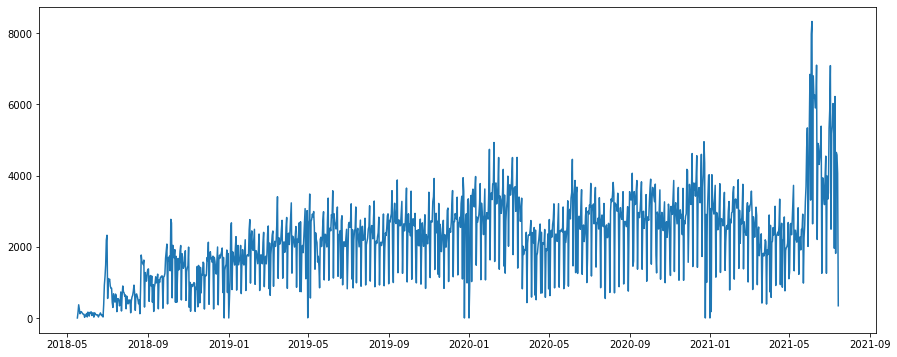

In [ ]:
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 15,6

#dateparse = lambda dates: dt.datetime.strptime(dates, '%d-%m-%y') 

ts = df2['Price'] 

plt.plot(df2['Timestamp'], ts)

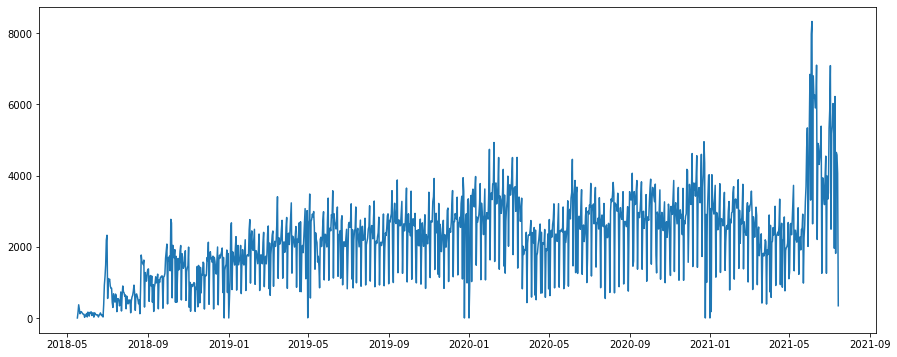

In [ ]:
# Gráfico da série por dia
df_year = df2
df_year = df.set_index('Timestamp', drop=False).groupby([pd.Grouper(key='Timestamp',freq='D')])['Price'].sum().reset_index()
df_year #= df_year.set_index('Timestamp')
plt.plot(df_year['Timestamp'],df_year['Price'])

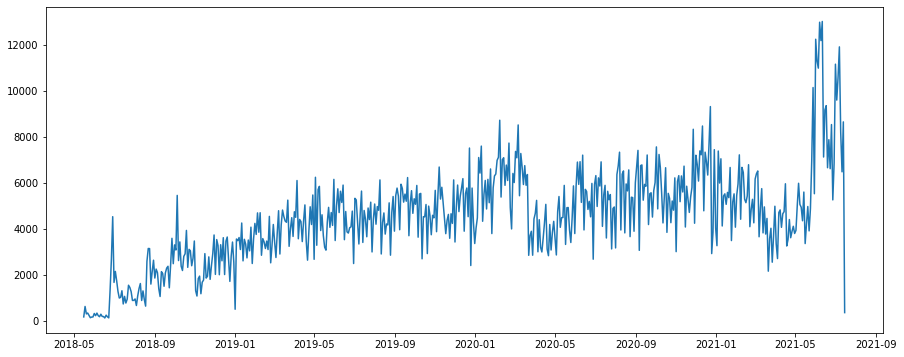

In [ ]:
# Gráfico da série a cada 2 DIAS
df_year = df2
df_year = df.set_index('Timestamp', drop=False).groupby([pd.Grouper(key='Timestamp',freq='2D')])['Price'].sum().reset_index()
df_year #= df_year.set_index('Timestamp')
plt.plot(df_year['Timestamp'],df_year['Price'])

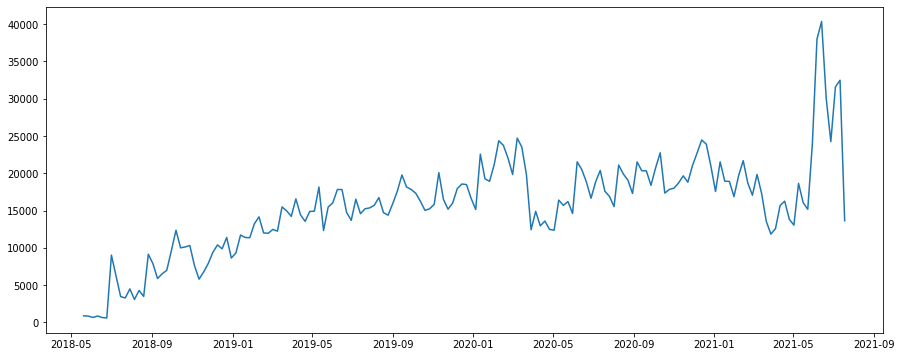

In [ ]:
# Gráfico da série por semana
df_year = df2
df_year = df.set_index('Timestamp', drop=False).groupby([pd.Grouper(key='Timestamp',freq='W')])['Price'].sum().reset_index()
df_year #= df_year.set_index('Timestamp')
plt.plot(df_year['Timestamp'],df_year['Price'])

## ARIMA MODEL

In [ ]:
from datetime import datetime
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S.000') 
series = pd.read_csv('Sales2.csv',  sep=';', na_values='?', header=0, parse_dates=['Timestamp'],date_parser=dateparse,index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
# Obtém a coluna Price(Somatório das vendas do dia)
df_class2 = df[['Timestamp', 'Price']].groupby(pd.Grouper(key='Timestamp', freq='1D')).sum()['Price']

In [ ]:
df_class2

Timestamp
2018-05-16       0.15
2018-05-17     156.34
2018-05-18     370.60
2018-05-19     239.73
2018-05-20     118.32
               ...   
2021-07-11    1814.46
2021-07-12    4651.45
2021-07-13    4578.15
2021-07-14    4059.69
2021-07-15     343.25
Freq: D, Name: Price, Length: 1157, dtype: float64

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                              ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                 1157
Model:                     ARMA(1, 0)   Log Likelihood               -9660.327
Method:                       css-mle   S.D. of innovations           1022.896
Date:                Sun, 05 Sep 2021   AIC                          19326.654
Time:                        00:13:04   BIC                          19341.815
Sample:                    05-16-2018   HQIC                         19332.376
                         - 07-15-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2227.4878     61.217     36.387      0.000    2107.505    2347.470
ar.L1.Price     0.5092      0.025     20.074      0.000       0.459       0.559
                                    Roots       

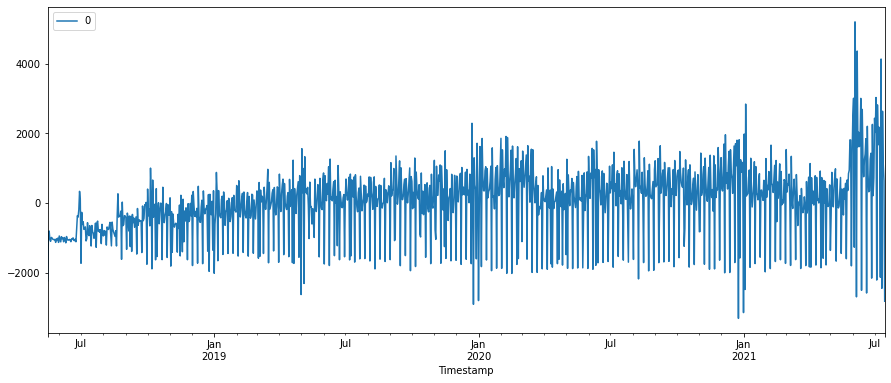

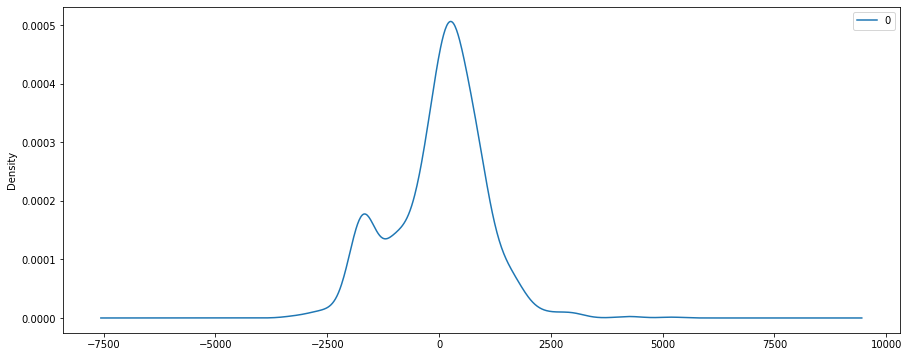

                 0
count  1157.000000
mean      0.992746
std    1023.881754
min   -3308.292362
25%    -554.343907
50%     163.930868
75%     635.272118
max    5199.060354


In [ ]:
# model = ARIMA(series2, order=(1,0,0))
# model_fit = model.fit(disp=0)
# print(model_fit.summary())
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

model = ARIMA(df_class2, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

predicted=2911.545490, expected=2813.920000
predicted=2430.977161, expected=2744.950000
predicted=2667.751487, expected=3251.790000
predicted=2900.487318, expected=3649.950000
predicted=3665.286747, expected=3899.420000
predicted=1817.607185, expected=1511.790000
predicted=3075.060353, expected=3342.230000
predicted=3056.451836, expected=3667.960000
predicted=2923.107162, expected=3551.700000
predicted=3338.426510, expected=3383.990000
predicted=3685.302901, expected=3265.920000
predicted=3836.363299, expected=3760.380000
predicted=1984.769075, expected=1767.920000
predicted=3333.690102, expected=1266.140000
predicted=3071.129772, expected=2977.180000
predicted=2843.978813, expected=2862.990000
predicted=2875.622122, expected=2499.080000
predicted=2832.602880, expected=3045.220000
predicted=3520.588537, expected=3598.470000
predicted=2180.699539, expected=1088.760000
predicted=1514.984030, expected=2744.690000
predicted=3102.007034, expected=2966.310000
predicted=2900.855473, expected=

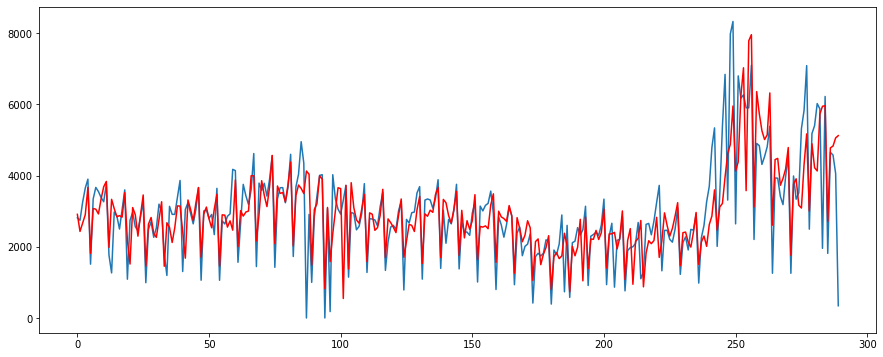

In [ ]:
#O modelo ARIMA com parâmetros 1,1,0 possui melhor resultado do que com 1,0,0 Test MSE: 1539142.829 1140194
X = df_class2.values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(6,1,2))
    model_fit = model.fit()#disp=0
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
print('rmse = ', np.sqrt(mean_squared_error(test, predictions)))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test, predictions)
mae

558.0493989700587

GRID SEARCH


In [ ]:
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [ ]:
# X has all time series values
X = df_class2.values

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1453.589
ARIMA(0, 0, 1) RMSE=1335.449
ARIMA(0, 0, 2) RMSE=1286.155
ARIMA(0, 1, 0) RMSE=1443.332
ARIMA(0, 1, 1) RMSE=1070.688
ARIMA(0, 2, 0) RMSE=2506.239
ARIMA(0, 2, 1) RMSE=1444.768
ARIMA(1, 0, 0) RMSE=1256.179
ARIMA(1, 0, 1) RMSE=1069.456
ARIMA(1, 0, 2) RMSE=1062.309
ARIMA(1, 1, 0) RMSE=1233.555
ARIMA(1, 1, 1) RMSE=1066.490
ARIMA(1, 1, 2) RMSE=1071.067
ARIMA(1, 2, 0) RMSE=1871.181
ARIMA(2, 0, 0) RMSE=1172.159
ARIMA(2, 0, 1) RMSE=1064.274


In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=100).mean()
    rolstd = pd.Series(timeseries).rolling(window=100).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
# Média móvel da série
test_stationarity(df_class2)

## Exponential Smoothing


In [ ]:
import pandas as pd
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

In [ ]:
# O objeto series é uma série com a data e o valor da venda
series = df_class2

In [ ]:
series

In [ ]:
#First Instance
ins1 = SimpleExpSmoothing(series).fit(smoothing_level=0.2,optimized=False)
ins1_cast = ins1.forecast(50)
ins1_fitted = ins1.fittedvalues

In [ ]:
#Second Instance
ins2 = SimpleExpSmoothing(series).fit(smoothing_level=0.6,optimized=False)
ins2_cast = ins2.forecast(3)
ins2_fitted = ins2.fittedvalues

In [ ]:
# Third Instance
ins3 = SimpleExpSmoothing(series).fit()
ins3_cast = ins3.forecast(3)
ins3_fitted = ins3.fittedvalues

In [ ]:
plt.plot(series, label='realdata', color='black')
# SES with alpha = 0.2
plt.plot(ins1_fitted, label='alpha0.2', color='red')
plt.plot(ins1_cast, label='alpha0.2cast', color = 'red')
plt.legend(loc=2)
plt.show()

In [ ]:
# RMSE para alpha = 0.2
error_alpha02 = mean_squared_error(series,ins1_fitted)
RMSE_alpha2 = math.sqrt(error_alpha02)
RMSE_alpha2

In [ ]:
# MAE para alpha = 0.2
mae_02 = mean_absolute_error(series,ins1_fitted)
mae_02

In [ ]:
# SES with alpha = 0.6
plt.plot(series, label='realdata', color='black')
plt.plot(ins2_fitted, label='alpha0.6', color='blue')
plt.plot(ins2_cast, label='alpha0.6cast', color = 'red')
plt.legend(loc=2)
plt.show()

In [ ]:
# RMSE para alpha = 0.6
error_alpha06 = mean_squared_error(series,ins2_fitted)
error_alpha06
RMSE_alpha6 = math.sqrt(error_alpha06)
RMSE_alpha6

In [ ]:
# MAE para alpha = 0.6
mae_06 = mean_absolute_error(series,ins2_fitted)
mae_06

In [ ]:
# SES com stats model 
plt.plot(series, label='realdata', color='black')
plt.plot(ins3_fitted, label='stats', color='green')
plt.plot(ins3_cast, label='statscast', color = 'green')
plt.legend(loc=2)
plt.show()

In [ ]:
error_stats = mean_squared_error(series,ins3_fitted)
error_stats
RMSE_stats = math.sqrt(error_stats)
RMSE_stats

In [ ]:
# Erro médio absoluto
mae_stats = mean_absolute_error(series,ins3_fitted)
mae_stats

## Holt Method

In [ ]:
from statsmodels.tsa.api import Holt

In [ ]:
# Holt 1
fit1 = Holt(series).fit(smoothing_level=0.8, smoothing_slope=0.2,optimized=False)
f1fit = fit1.fittedvalues

In [ ]:
# Holt 2
fit2 = Holt(series,damped=True).fit(smoothing_level=0.8,smoothing_slope=0.2)
f2fit = fit2.fittedvalues

In [ ]:
# Plotando Holt 1 vs Serie temporal
plt.plot(series, label='realdata', color='black')
# Holt 1 = 0.2
plt.plot(f1fit, label='holt1', color='green')
plt.legend(loc=2)
plt.show()

In [ ]:
# Erro do método Holt 1
error_holt1 = mean_squared_error(series,f1fit)
error_holt1

In [ ]:
# Plotando Holt 1 vs Serie temporal
plt.plot(series, label='realdata', color='black')
# Holt 1 = 0.2
plt.plot(f2fit, label='holt2', color='red')
plt.legend(loc=2)
plt.show()

In [ ]:
# Erro do método Holt 2
error_holt2 = mean_squared_error(series,f2fit)
error_holt2